# Imports

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.colors import ListedColormap

from IPython.display import display

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, fcluster
from kmodes.kprototypes import KPrototypes

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', message='The objective has been evaluated at point')

# Data

In [2]:
raw_data_customers = pd.read_csv('customers-segmented.csv', index_col=0)
# raw_data_customers = pd.read_csv('customers-segmented-kprot4.csv', index_col=0)

In [3]:
df_customers = raw_data_customers.copy()
# df_customers_nocluster = df_customers.drop('Cluster', axis=1)
display(df_customers.describe())
display(df_customers.groupby('Cluster').mean().round(3))

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cluster
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.0000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000,1.9360
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533,0.9388
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000,1.0000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000,1.0000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000,2.0000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000,3.0000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000,4.0000


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Cluster,,,,,,,
1,0.496,0.513,34.619,1.000,115413.113,0.825,0.716
2,0.559,0.536,31.907,0.898,81766.741,0.239,0.214
3,0.312,0.446,40.703,1.193,152156.739,1.228,1.216
4,0.291,0.400,44.727,1.345,223444.564,1.745,1.455


In [4]:
df_customers_features = df_customers.reset_index().drop(columns=['ID', 'Cluster'])
df_customers_clusters = df_customers.reset_index()['Cluster']

customers_features = ['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']

In [5]:
df_new_customers = pd.DataFrame([ # hierarchical
{'ID':100002001,'Sex':0,'Marital status':1,'Age':35,'Education':1,'Income':115000,'Occupation':1,'Settlement size':1}, # expect 1
{'ID':100002002,'Sex':1,'Marital status':1,'Age':32,'Education':1,'Income':82000,'Occupation':0,'Settlement size':0}, # expect 2
{'ID':100002003,'Sex':0,'Marital status':0,'Age':41,'Education':1,'Income':152000,'Occupation':1,'Settlement size':1}, # expect 3
{'ID':100002004,'Sex':0,'Marital status':0,'Age':45,'Education':1,'Income':223000,'Occupation':2,'Settlement size':1}, # expect 4
{'ID':100002005,'Sex':0,'Marital status':0,'Age':36,'Education':1,'Income':121000,'Occupation':1,'Settlement size':1}, # dataset mean
{'ID':100002006,'Sex':1,'Marital status':0,'Age':31,'Education':2,'Income':120000,'Occupation':1,'Settlement size':2}, # young unmarried career-focussed woman
{'ID':100002007,'Sex':0,'Marital status':1,'Age':50,'Education':2,'Income':90000,'Occupation':0,'Settlement size':0}, # old married man with education but little career
{'ID':100002008,'Sex':0,'Marital status':0,'Age':28,'Education':0,'Income':90000,'Occupation':0,'Settlement size':2}, # young unmarried male with unsuccessful career in a big city
{'ID':100002009,'Sex':0,'Marital status':0,'Age':58,'Education':0,'Income':284597,'Occupation':0,'Settlement size':1}, # old unmarried man with little education and unknown occupation but huge income
{'ID':100002010,'Sex':1,'Marital status':1,'Age':21,'Education':3,'Income':151823,'Occupation':2,'Settlement size':2}, # young married very-well-educated woman in a good job in a big city with a decent income
{'ID':100002011,'Sex':1,'Marital status':1,'Age':64,'Education':2,'Income':107499,'Occupation':2,'Settlement size':0}, # old married education woman with a median-paid good job in a small city
]).set_index('ID')

# df_new_customers = pd.DataFrame([ # k-prototypes
# {'ID':100002001,'Sex':0,'Marital status':0,'Age':41,'Education':1,'Income':154000,'Occupation':1,'Settlement size':1}, # expect 1
# {'ID':100002002,'Sex':1,'Marital status':1,'Age':32,'Education':1,'Income':79000,'Occupation':0,'Settlement size':0}, # expect 2
# {'ID':100002003,'Sex':0,'Marital status':0,'Age':45,'Education':1,'Income':225000,'Occupation':2,'Settlement size':1}, # expect 3
# {'ID':100002004,'Sex':1,'Marital status':1,'Age':34,'Education':1,'Income':115000,'Occupation':1,'Settlement size':1}, # expect 4
# {'ID':100002005,'Sex':0,'Marital status':0,'Age':36,'Education':1,'Income':121000,'Occupation':1,'Settlement size':1}, # dataset mean
# {'ID':100002006,'Sex':1,'Marital status':0,'Age':31,'Education':2,'Income':120000,'Occupation':1,'Settlement size':2}, # young unmarried career-focussed woman
# {'ID':100002007,'Sex':0,'Marital status':1,'Age':50,'Education':2,'Income':90000,'Occupation':0,'Settlement size':0}, # old married man with education but little career
# {'ID':100002008,'Sex':0,'Marital status':0,'Age':28,'Education':0,'Income':90000,'Occupation':0,'Settlement size':2}, # young unmarried man with unsuccessful career in a big city
# {'ID':100002009,'Sex':0,'Marital status':0,'Age':58,'Education':0,'Income':284597,'Occupation':0,'Settlement size':1}, # old unmarried man with little education and unknown occupation but huge income
# {'ID':100002010,'Sex':1,'Marital status':1,'Age':21,'Education':3,'Income':151823,'Occupation':2,'Settlement size':2}, # young married very-well-educated woman in a good job in a big city with a decent income
# {'ID':100002011,'Sex':1,'Marital status':1,'Age':64,'Education':2,'Income':107499,'Occupation':2,'Settlement size':0}, # old married education woman with a median-paid good job in a small city
# ]).set_index('ID')

# {'ID':100002009,'Sex':random.randint(0,1),'Marital status':random.randint(0,1),'Age':random.randint(18,70),'Education':random.randint(0,3),'Income':random.randint(30000,300000),'Occupation':random.randint(0,2),'Settlement size':random.randint(0,2)}, # random

# {'ID':100002009,'Sex':0,'Marital status':0,'Age':58,'Education':0,'Income':284597,'Occupation':0,'Settlement size':1}, # old unmarried man with little education and unknown occupation but huge income
# {'ID':100002010,'Sex':1,'Marital status':1,'Age':21,'Education':3,'Income':151823,'Occupation':2,'Settlement size':2}, # young married very-well-educated woman in a good job in a big city with a decent income
# {'ID':100002011,'Sex':1,'Marital status':1,'Age':64,'Education':2,'Income':107499,'Occupation':2,'Settlement size':0}, # old married education woman with a median-paid good job in a small city

df_new_customers

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100002001,0,1,35,1,115000,1,1
100002002,1,1,32,1,82000,0,0
100002003,0,0,41,1,152000,1,1
100002004,0,0,45,1,223000,2,1
100002005,0,0,36,1,121000,1,1
100002006,1,0,31,2,120000,1,2
100002007,0,1,50,2,90000,0,0
100002008,0,0,28,0,90000,0,2
100002009,0,0,58,0,284597,0,1


In [6]:
scaler = StandardScaler()
df_customers_features_scaled = scaler.fit_transform(df_customers_features)
df_new_customers_scaled = scaler.transform(df_new_customers)

# Plots

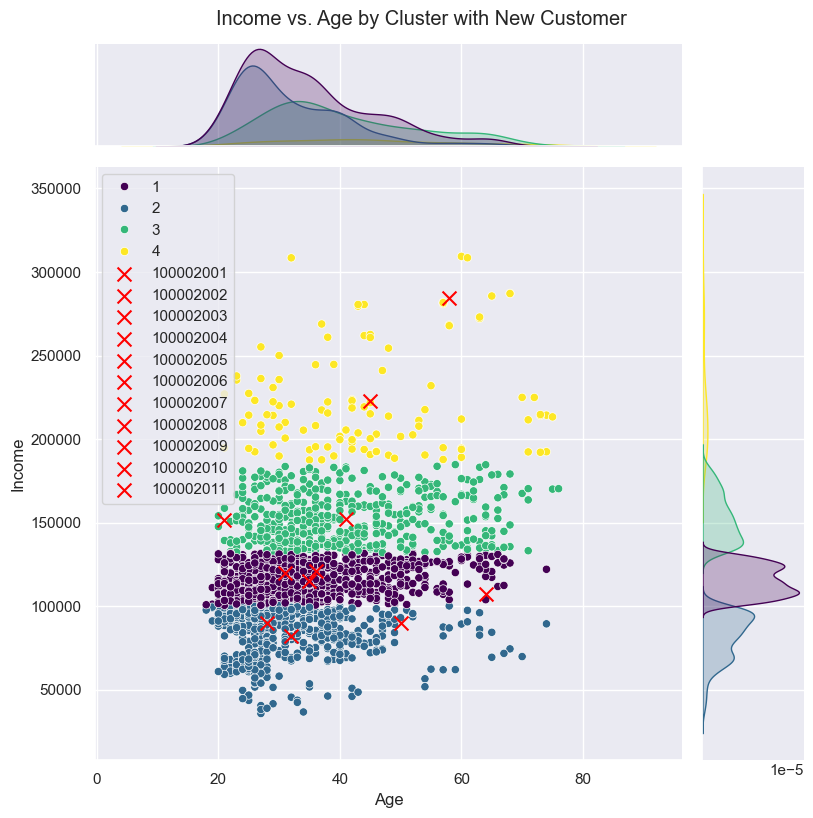

In [7]:
sns.jointplot(data=df_customers, x='Age', y='Income', hue='Cluster', palette='viridis', kind='scatter', height=8)
for _, new_customer in df_new_customers.iterrows():
    plt.scatter(data=new_customer, x='Age', y='Income', color='red', marker='x', s=100, label=new_customer.name)
plt.legend()
plt.suptitle("Income vs. Age by Cluster with New Customer", y=1.02)
plt.show()

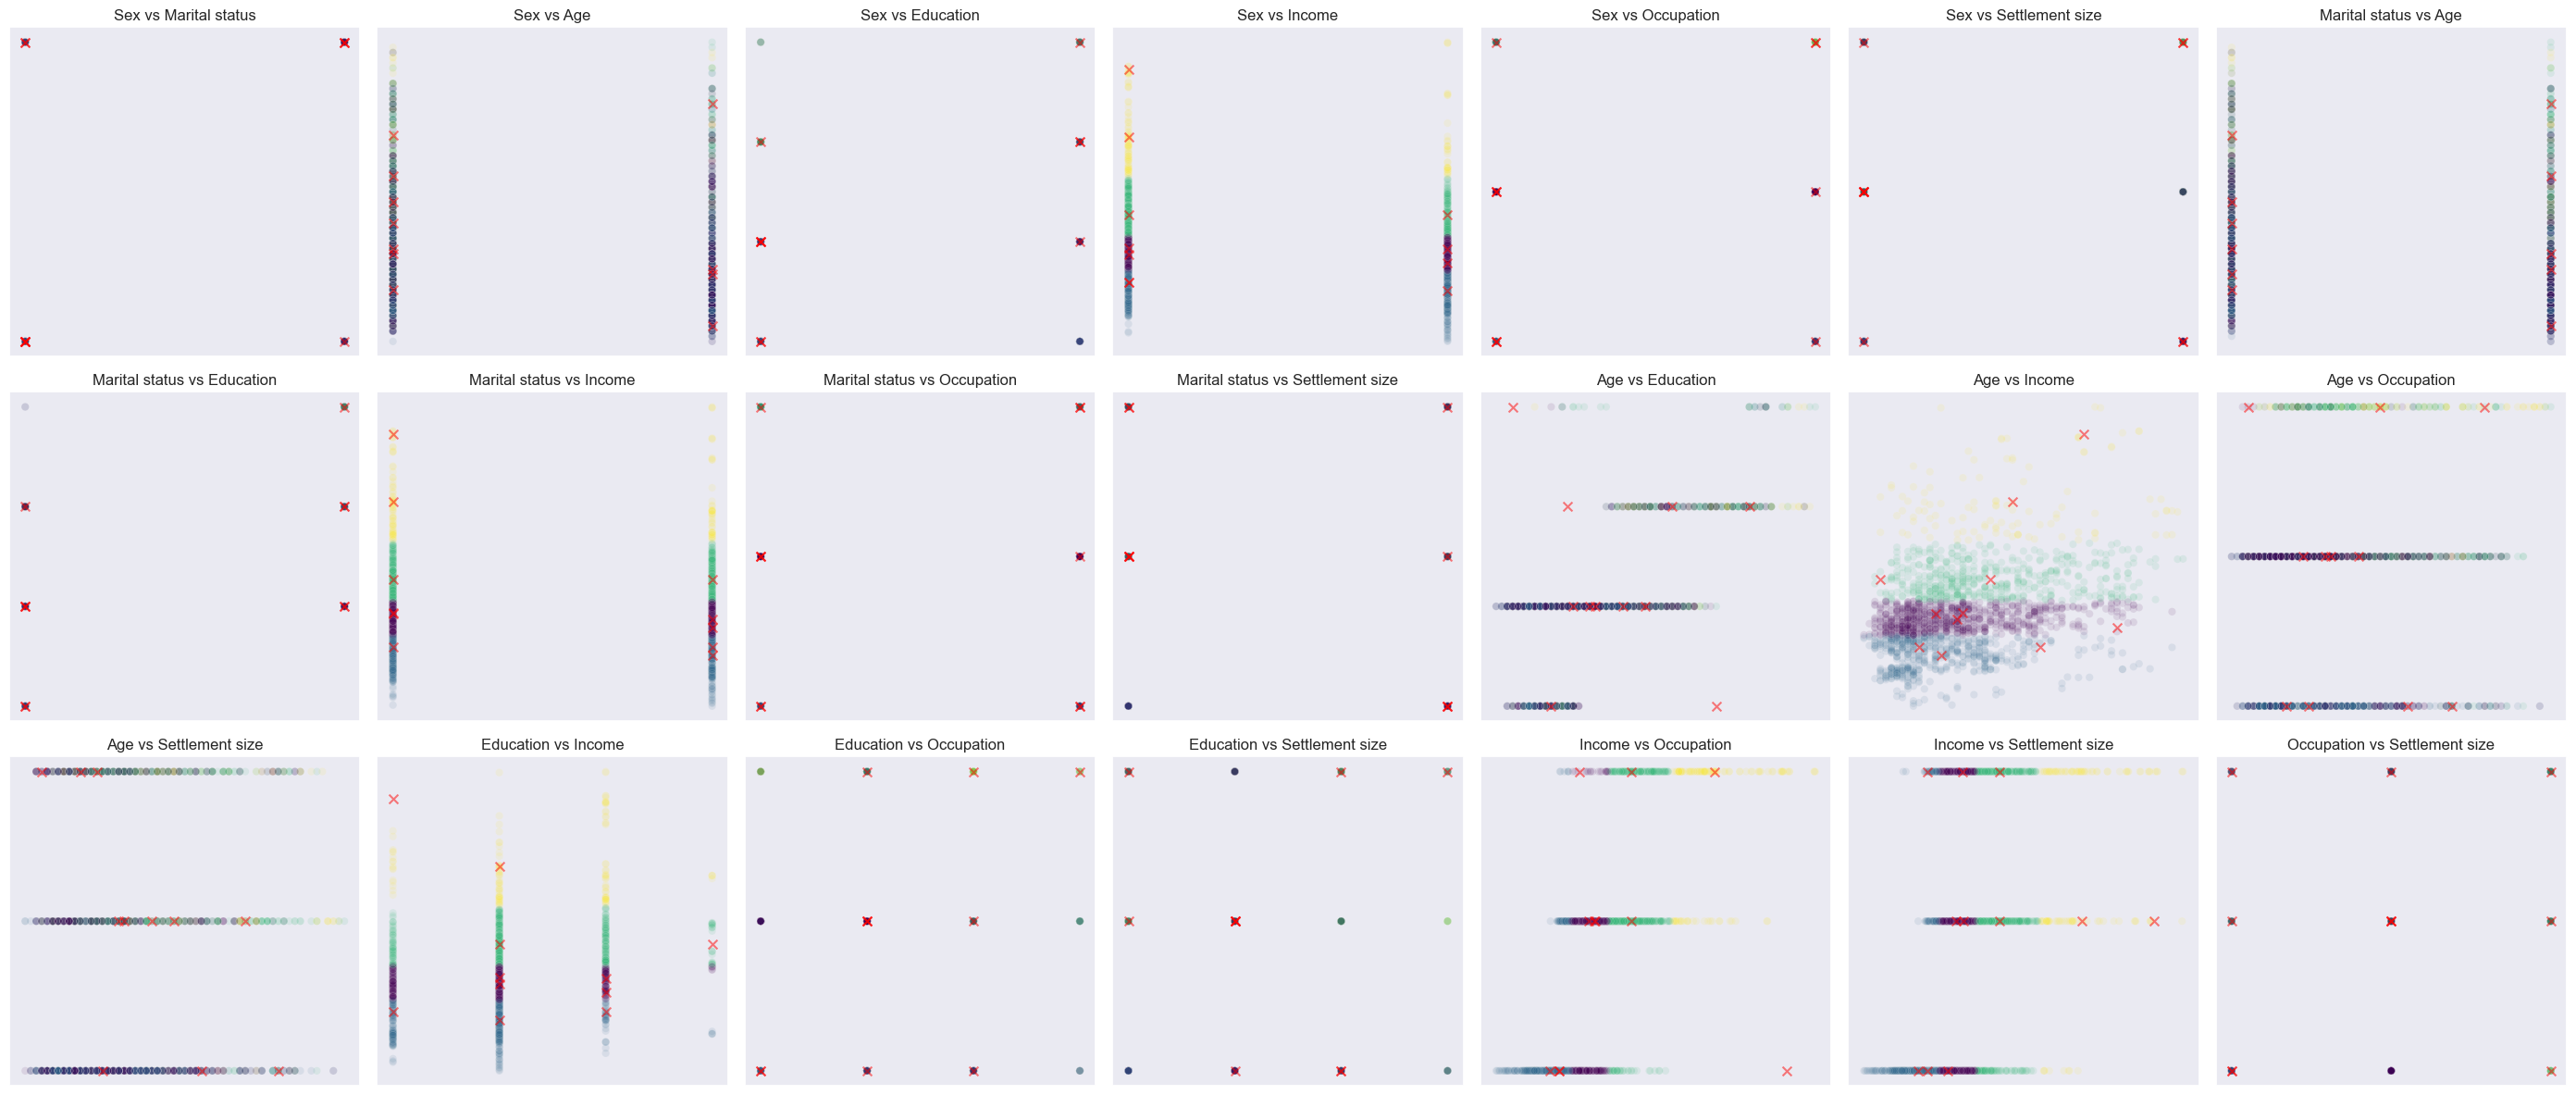

In [8]:
fig, axes = plt.subplots(3, 7, figsize=(28,12), sharex=False, sharey=False)
axes = axes.flatten()
plot_idx = 0
for i, x_col in enumerate(customers_features):
    for j, y_col in enumerate(customers_features):
        if i < j:
            ax = axes[plot_idx]
            sns.scatterplot(data=df_customers, x=x_col, y=y_col, hue='Cluster', palette='viridis', alpha=0.1, ax=ax, legend=False)
            for _, new_customer in df_new_customers.iterrows():
                ax.scatter(new_customer[x_col], new_customer[y_col], color='red', alpha=0.5, marker='x', s=50, label='New')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title(f'{x_col} vs {y_col}')
            plot_idx += 1
plt.tight_layout()
plt.show()

# Classification

In [9]:
results = pd.DataFrame(index=[df_new_customers.index])

## Re-cluster

### Hierarchical

In [10]:
df_customers_including_new = pd.concat([df_customers.drop('Cluster', axis=1), df_new_customers])

Z = linkage(df_customers_including_new, method='ward')
df_customers_including_new['Cluster'] = fcluster(Z, t=4, criterion='maxclust')

for _, new_customer in df_customers_including_new[-len(df_new_customers):].iterrows():
    print(f'New customer {int(new_customer.name)} assigned to cluster: {new_customer.Cluster}')

results = results.merge(pd.DataFrame(df_customers_including_new.iloc[-len(df_new_customers):].Cluster.to_list(), index=[df_new_customers.index], columns=['Recluster']), left_index=True, right_index=True)

df_customers_original_analysis = df_customers.groupby(['Cluster']).mean()
df_customers_original_analysis['#'] = df_customers[['Cluster','Sex']].groupby(['Cluster']).count()
df_customers_original_analysis['%'] = df_customers_original_analysis['#'] / df_customers_original_analysis['#'].sum()

df_customers_including_new_analysis = df_customers_including_new.groupby(['Cluster']).mean()
df_customers_including_new_analysis['#'] = df_customers_including_new[['Cluster','Sex']].groupby(['Cluster']).count()
df_customers_including_new_analysis['%'] = df_customers_including_new_analysis['#'] / df_customers_including_new_analysis['#'].sum()

display(df_customers_original_analysis.sort_values('#', ascending=False).round(2))
display(df_customers_including_new_analysis.sort_values('#', ascending=False).round(2))

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,#,%
Cluster,,,,,,,,,
1,0.50,0.51,34.62,1.00,115413.11,0.82,0.72,839,0.42
2,0.56,0.54,31.91,0.90,81766.74,0.24,0.21,560,0.28
3,0.31,0.45,40.70,1.19,152156.74,1.23,1.22,491,0.25
4,0.29,0.40,44.73,1.35,223444.56,1.75,1.45,110,0.06


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,#,%
Cluster,,,,,,,,,
1,0.50,0.51,34.65,1.00,115415.30,0.83,0.72,843,0.42
2,0.56,0.54,31.93,0.90,81796.40,0.24,0.22,563,0.28
3,0.31,0.45,40.66,1.20,152155.74,1.23,1.22,493,0.25
4,0.29,0.39,44.85,1.33,223986.60,1.73,1.45,112,0.06


### K-prototypes

In [11]:
# df_customers_including_new = pd.concat([df_customers.drop('Cluster', axis=1), df_new_customers])

# kprot_4 = KPrototypes(n_clusters=4, init='Cao', n_init=10, verbose=0, random_state=42)
# df_customers_including_new['Cluster'] = kprot_4.fit_predict(df_customers_including_new, categorical=[0,1,3,5,6]) +1

# for _, new_customer in df_customers_including_new[-len(df_new_customers):].iterrows():
#     print(f'New customer {int(new_customer.name)} assigned to cluster: {new_customer.Cluster}')

# results = results.merge(pd.DataFrame(df_customers_including_new.iloc[-len(df_new_customers):].Cluster.to_list(), index=[df_new_customers.index], columns=['Recluster']), left_index=True, right_index=True)

# df_customers_original_analysis = df_customers.groupby(['Cluster']).mean()
# df_customers_original_analysis['#'] = df_customers[['Cluster','Sex']].groupby(['Cluster']).count()
# df_customers_original_analysis['%'] = df_customers_original_analysis['#'] / df_customers_original_analysis['#'].sum()

# df_customers_including_new_analysis = df_customers_including_new.groupby(['Cluster']).mean()
# df_customers_including_new_analysis['#'] = df_customers_including_new[['Cluster','Sex']].groupby(['Cluster']).count()
# df_customers_including_new_analysis['%'] = df_customers_including_new_analysis['#'] / df_customers_including_new_analysis['#'].sum()

# display(df_customers_original_analysis.sort_values('#', ascending=False).round(2))
# display(df_customers_including_new_analysis.sort_values('#', ascending=False).round(2))

## Distance from cluster centroids

In [12]:
df_centroids = df_customers_features.groupby(df_customers_clusters).mean()
df_centroids_scaled = scaler.transform(df_centroids)
temp_clusters = []
for i, new_customer in enumerate(df_new_customers_scaled):
    distances = np.linalg.norm(df_centroids_scaled - new_customer, axis=1)
    assigned_cluster = df_centroids.index[np.argmin(distances)]
    print(f'New customer {int(df_new_customers.iloc[i].name)} assigned to cluster: {str(assigned_cluster)}')
    temp_clusters.append(int(assigned_cluster))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['DfCC']), left_index=True, right_index=True)

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 3
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 1
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 3


## K-nearest neighbours (KNN)

### Majority

In [13]:
temp_clusters = []
for i, new_customer in enumerate(df_new_customers_scaled):
    knn_assignment = []
    for n in range(1,101):
        for w in ['uniform', 'distance']:
            knn = KNeighborsClassifier(n_neighbors=n, weights=w)
            knn.fit(df_customers_features_scaled, df_customers_clusters)
            assigned_cluster_knn = knn.predict(new_customer.reshape(1, -1))
            knn_assignment.append(int(assigned_cluster_knn[0]))
    assignment_counts = Counter(knn_assignment)
    max_n = max(assignment_counts.values())
    top_clusters = [(c, n) for c, n in assignment_counts.items() if n == max_n]
    top_clusters_str = ''
    for c, n in top_clusters:
        print(f'New customer {int(df_new_customers.iloc[i].name)} assigned to cluster {c}: {n*100/sum(assignment_counts.values()):.1f}%')
        top_clusters_str += f'{c} '
    print()
    top_clusters_str = top_clusters_str.strip()
    if len(top_clusters) > 1:
        temp_clusters.append(top_clusters_str)
    else:
        temp_clusters.append(int(c))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['KNN (M)']), left_index=True, right_index=True)

New customer 100002001 assigned to cluster 1: 100.0%

New customer 100002002 assigned to cluster 2: 100.0%

New customer 100002003 assigned to cluster 3: 83.0%

New customer 100002004 assigned to cluster 4: 73.0%

New customer 100002005 assigned to cluster 1: 100.0%

New customer 100002006 assigned to cluster 1: 100.0%

New customer 100002007 assigned to cluster 2: 99.5%

New customer 100002008 assigned to cluster 1: 55.0%

New customer 100002009 assigned to cluster 3: 54.0%

New customer 100002010 assigned to cluster 3: 100.0%

New customer 100002011 assigned to cluster 3: 73.0%



### Optimum

In [14]:
parameters = {'n_neighbors': range(1, 101), 'weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, scoring='accuracy', cv=5)
grid_search_knn.fit(df_customers_features_scaled, df_customers_clusters)

print(f'Best score: {grid_search_knn.best_score_}')
print(f'Best parameters: {grid_search_knn.best_params_}')
print()

temp_clusters = []
for i, new_customer in enumerate(df_new_customers_scaled):
    assigned_cluster_knn = grid_search_knn.best_estimator_.predict(pd.DataFrame([new_customer]))
    print(f'New customer {int(df_new_customers.iloc[i].name)} assigned to cluster: {assigned_cluster_knn[0]}')
    temp_clusters.append(int(assigned_cluster_knn[0]))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['KNN (O)']), left_index=True, right_index=True)

Best score: 0.8714999999999999
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 3


## Random forest

### Basic

In [15]:
rf = RandomForestClassifier(random_state=42)
rf.fit(df_customers_features, df_customers_clusters)
temp_clusters = []
for _, new_customer in df_new_customers.iterrows():
    assigned_cluster_rf = rf.predict(pd.DataFrame([new_customer], columns=customers_features))
    print(f'New customer {int(new_customer.name)} assigned to cluster: {assigned_cluster_rf[0]}')
    temp_clusters.append(int(assigned_cluster_rf[0]))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['RF']), left_index=True, right_index=True)

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 3
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


### BayesSearchCV

In [16]:
ss_rf = {
    'n_estimators': (50 , 300),
    'max_depth': (1, 30, None),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None],
}
bayes_search_rf = BayesSearchCV(estimator=RandomForestClassifier(random_state=42), search_spaces=ss_rf, n_iter=100, scoring='accuracy', cv=5)
bayes_search_rf.fit(df_customers_features, df_customers_clusters)
print(f'Best score: {bayes_search_rf.best_score_}')
print(f'Best parameters: {bayes_search_rf.best_params_}')
print()

temp_clusters = []
for _, new_customer in df_new_customers.iterrows():
    assigned_cluster_rf = bayes_search_rf.best_estimator_.predict(pd.DataFrame([new_customer], columns=customers_features))
    print(f'New customer {int(new_customer.name)} assigned to cluster: {assigned_cluster_rf[0]}')
    temp_clusters.append(int(assigned_cluster_rf[0]))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['RF-B']), left_index=True, right_index=True)

Best score: 1.0
Best parameters: OrderedDict({'bootstrap': False, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 12, 'n_estimators': 56})

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


### BayesSearchCV for scaled data

In [17]:
ss_rf = {
    'n_estimators': (50 , 300),
    'max_depth': (1, 30, None),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None],
}
bayes_search_rf_s = BayesSearchCV(estimator=RandomForestClassifier(random_state=42), search_spaces=ss_rf, n_iter=100, scoring='accuracy', cv=5)
bayes_search_rf_s.fit(df_customers_features_scaled, df_customers_clusters)
print(f'Best score: {bayes_search_rf_s.best_score_}')
print(f'Best parameters: {bayes_search_rf_s.best_params_}')
print()

temp_clusters = []
for i, new_customer in enumerate(df_new_customers_scaled):
    assigned_cluster_rf = bayes_search_rf_s.best_estimator_.predict(pd.DataFrame([new_customer]))
    print(f'New customer {int(df_new_customers.iloc[i].name)} assigned to cluster: {assigned_cluster_rf[0]}')
    temp_clusters.append(int(assigned_cluster_rf[0]))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['RF-B-S']), left_index=True, right_index=True)

c:\Users\jgibb\miniconda3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best score: 1.0
Best parameters: OrderedDict({'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 141})

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


## XGBoost

In [18]:
xgb = XGBClassifier(random_state=42)
xgb.fit(df_customers_features, df_customers_clusters-1)
temp_clusters = []
for _, new_customer in df_new_customers.iterrows():
    predicted_cluster_xgb = xgb.predict(pd.DataFrame([new_customer], columns=customers_features))
    print(f'New customer {int(new_customer.name)} assigned to cluster: {predicted_cluster_xgb[0]+1}')
    temp_clusters.append(int(predicted_cluster_xgb[0]+1))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['XGB']), left_index=True, right_index=True)

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


### BayesSearchCV

In [19]:
ss_xgb = {
    'max_depth': (1, 10),
    'learning_rate': (0.01, 0.5),
    'n_estimators': (50, 300),
    'subsample': (0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (1, 10)
}

bayes_search_xgb = BayesSearchCV(estimator=XGBClassifier(random_state=42), search_spaces=ss_xgb, n_iter=100, scoring='accuracy', cv=5)
bayes_search_xgb.fit(df_customers_features, df_customers_clusters-1)
print(f'Best score: {bayes_search_xgb.best_score_}')
print(f'Best parameters: {bayes_search_xgb.best_params_}')
print()

temp_clusters = []
for _, new_customer in df_new_customers.iterrows():
    predicted_cluster_xgb = bayes_search_xgb.best_estimator_.predict(pd.DataFrame([new_customer], columns=customers_features))
    print(f'New customer {int(new_customer.name)} assigned to cluster: {predicted_cluster_xgb[0]+1}')
    temp_clusters.append(int(predicted_cluster_xgb[0]+1))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['XGB-B']), left_index=True, right_index=True)

Best score: 0.9970000000000001
Best parameters: OrderedDict({'colsample_bytree': 0.19485461510348717, 'learning_rate': 0.3653703387748852, 'max_depth': 7, 'n_estimators': 246, 'reg_alpha': 0.2528633015632666, 'reg_lambda': 1, 'subsample': 0.5591308000231484})

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


### BayesSearchCV for scaled data

In [20]:
ss_xgb = {
    'max_depth': (1, 10),
    'learning_rate': (0.01, 0.5),
    'n_estimators': (50, 300),
    'subsample': (0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (1, 10)
}

bayes_search_xgb_s = BayesSearchCV(estimator=XGBClassifier(random_state=42), search_spaces=ss_xgb, n_iter=100, scoring='accuracy', cv=5)
bayes_search_xgb_s.fit(df_customers_features_scaled, df_customers_clusters-1)
print(f'Best score: {bayes_search_xgb_s.best_score_}')
print(f'Best parameters: {bayes_search_xgb_s.best_params_}')
print()

temp_clusters = []
for i, new_customer in enumerate(df_new_customers_scaled):
    predicted_cluster_xgb = bayes_search_xgb_s.best_estimator_.predict(pd.DataFrame([new_customer]))
    print(f'New customer {int(df_new_customers.iloc[i].name)} assigned to cluster: {predicted_cluster_xgb[0]+1}')
    temp_clusters.append(int(predicted_cluster_xgb[0]+1))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['XGB-B-S']), left_index=True, right_index=True)

Best score: 0.9970000000000001
Best parameters: OrderedDict({'colsample_bytree': 0.9935500178851738, 'learning_rate': 0.3850665696908449, 'max_depth': 3, 'n_estimators': 290, 'reg_alpha': 0.3471052003137303, 'reg_lambda': 5, 'subsample': 0.458185901670782})

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


## Logistic regression

In [21]:
logreg = LogisticRegression(random_state=42)
logreg.fit(df_customers_features_scaled, df_customers_clusters)
temp_clusters = []
for i, new_customer in enumerate(df_new_customers_scaled):
    predicted_cluster_lr = logreg.predict(pd.DataFrame([new_customer]))
    print(f'New customer {int(df_new_customers.iloc[i].name)} assigned to cluster: {predicted_cluster_lr[0]}')
    temp_clusters.append(int(predicted_cluster_lr[0]))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['LR']), left_index=True, right_index=True)

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


### BayesSearchCV

In [22]:
ss_logreg = {
    'C': (0.01, 100),
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'saga', 'sag'],
}

bayes_search_lr = BayesSearchCV(LogisticRegression(random_state=42), search_spaces=ss_logreg, n_iter=100, scoring='accuracy', cv=5)
bayes_search_lr.fit(df_customers_features_scaled, df_customers_clusters)
print("Best score:", bayes_search_lr.best_score_)
print("Best parameters:", bayes_search_lr.best_params_)
print()

temp_clusters = []
for i, new_customer in enumerate(df_new_customers_scaled):
    predicted_cluster_lr = bayes_search_lr.best_estimator_.predict(pd.DataFrame([new_customer]))
    print(f'New customer {int(df_new_customers.iloc[i].name)} assigned to cluster: {predicted_cluster_lr[0]}')
    temp_clusters.append(int(predicted_cluster_lr[0]))
results = results.merge(pd.DataFrame(temp_clusters, index=[df_new_customers.index], columns=['LR-B']), left_index=True, right_index=True)

Best score: 0.9935
Best parameters: OrderedDict({'C': 72.87123964026617, 'penalty': 'l2', 'solver': 'lbfgs'})

New customer 100002001 assigned to cluster: 1
New customer 100002002 assigned to cluster: 2
New customer 100002003 assigned to cluster: 3
New customer 100002004 assigned to cluster: 4
New customer 100002005 assigned to cluster: 1
New customer 100002006 assigned to cluster: 1
New customer 100002007 assigned to cluster: 2
New customer 100002008 assigned to cluster: 2
New customer 100002009 assigned to cluster: 4
New customer 100002010 assigned to cluster: 3
New customer 100002011 assigned to cluster: 1


# Results

In [23]:
results

,Recluster,DfCC,KNN (M),KNN (O),RF,RF-B,RF-B-S,XGB,XGB-B,XGB-B-S,LR,LR-B
ID,,,,,,,,,,,,
100002001,1,1,1,1,1,1,1,1,1,1,1,1
100002002,2,2,2,2,2,2,2,2,2,2,2,2
100002003,3,3,3,3,3,3,3,3,3,3,3,3
100002004,4,4,4,4,4,4,4,4,4,4,4,4
100002005,1,1,1,1,1,1,1,1,1,1,1,1
100002006,1,3,1,1,1,1,1,1,1,1,1,1
100002007,2,2,2,2,2,2,2,2,2,2,2,2
100002008,2,1,1,2,2,2,2,2,2,2,2,2
100002009,4,4,3,4,3,4,4,4,4,4,4,4


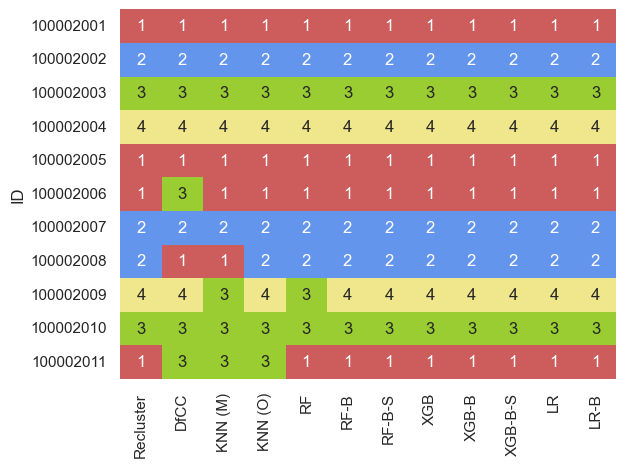

In [24]:
sns.heatmap(results, annot=True, cmap=ListedColormap(['indianred', 'cornflowerblue', 'yellowgreen', 'khaki']), cbar=False)
plt.show()

In [25]:
results_mean = pd.DataFrame(results.T.mean()).round(2).rename(columns={0:'Mean'})
results_mode = pd.DataFrame(results.T.agg(lambda x: x.mode()[0])).rename(columns={0:'Mode'})
pd.merge(left=results_mean, right=results_mode, left_index=True, right_index=True)

,Mean,Mode
ID,,
100002001,1.00,1
100002002,2.00,2
100002003,3.00,3
100002004,4.00,4
100002005,1.00,1
100002006,1.17,1
100002007,2.00,2
100002008,1.83,2
100002009,3.83,4
